In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-kcyy456s
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-kcyy456s
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 16.3 MB/s eta 0:00:00


✅ Processed 6899 images into CLIP embeddings & saved in FAISS
cat
✅ Top 3 matching images for: cat


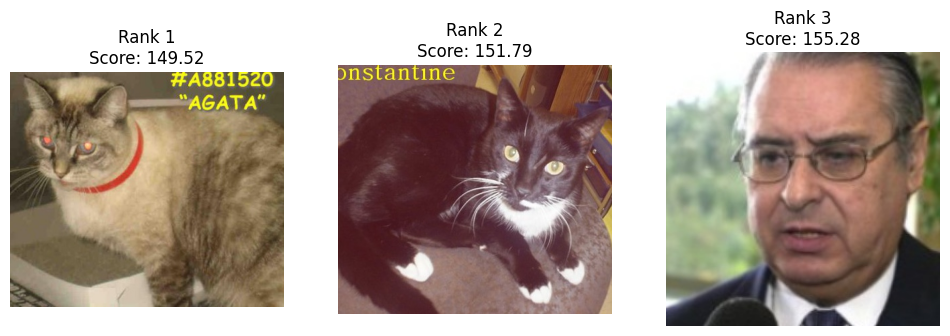

In [7]:
import torch
import clip
import faiss
import numpy as np
import kagglehub
import os
import zipfile
from PIL import Image
import glob
import matplotlib.pyplot as plt

# ✅ Step 1: Download Dataset
dataset_path = kagglehub.dataset_download("prasunroy/natural-images")
dataset_folder = os.path.join(dataset_path, "natural_images")

# ✅ Step 2: Extract dataset (if needed)
zip_file = os.path.join(dataset_path, "natural_images.zip")
if os.path.exists(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(dataset_folder)

# ✅ Step 3: Load CLIP Model (Adjust for CPU/GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# ✅ Use FP16 only if on CUDA
# Instead of changing the model type, ensure inputs are converted:
# if device == "cuda":
#     model = model.eval().to(device).half()  # Ensure model uses FP16 on GPU
# else:
#     model = model.eval().to(device) # Keep model in FP32 on CPU
model = model.eval().to(device)


# ✅ Step 4: Load All Images from Dataset
image_paths = glob.glob(os.path.join(dataset_folder, "*/*.jpg"))  # Adjust file type if needed

# ✅ Initialize Storage for Embeddings
image_embeddings = []
image_filenames = []

# ✅ Step 5: Process and Encode Images
for image_path in image_paths:
    img = Image.open(image_path).convert("RGB")  # Ensure RGB format
    img_tensor = preprocess(img).unsqueeze(0).to(device)  # Preprocess image for CLIP

    with torch.no_grad():
        # If on CUDA, use half precision for input, otherwise float32
        # The model will handle internal type conversions
        img_embedding = model.encode_image(img_tensor.type(torch.half if device == "cuda" else torch.float32)).cpu().numpy()  # Get CLIP embeddings

    image_embeddings.append(img_embedding)
    image_filenames.append(image_path)
# ✅ Convert to NumPy Array
image_embeddings = np.vstack(image_embeddings).astype("float32")

# ✅ Step 6: Save Embeddings & Store in FAISS
np.save("image_embeddings.npy", image_embeddings)
np.save("image_filenames.npy", np.array(image_filenames))

index = faiss.IndexFlatL2(512)  # FAISS index with L2 distance
index.add(image_embeddings)  # Add embeddings to FAISS
faiss.write_index(index, "faiss_index.index")  # Save FAISS index

print(f"✅ Processed {len(image_embeddings)} images into CLIP embeddings & saved in FAISS")

# ✅ Function to Search Images with Text
def encode_text(text: str):
    text_tokens = clip.tokenize([text]).to(device)
    with torch.no_grad():
        # Do not convert text_tokens to half precision, keep it as Long
        text_embedding = model.encode_text(text_tokens).cpu().numpy()
    return text_embedding
# ✅ Step 7: Example Query (Text-to-Image)
query_text = input()
query_embedding = encode_text(query_text)

# Load FAISS index
index = faiss.read_index("faiss_index.index")
image_filenames = np.load("image_filenames.npy")

# Search for top 3 similar images
distances, indices = index.search(query_embedding, 3)

# ✅ Display Results using Matplotlib
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

print("✅ Top 3 matching images for:", query_text)
for i, idx in enumerate(indices[0]):
    image_path = image_filenames[idx]
    img = Image.open(image_path)

    # Show image
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Rank {i+1}\nScore: {distances[0][i]:.2f}")

plt.show()